# Projet QI : Étude du modèle de masse de l’aile de l’avion CESSNA C172 Skyhawk

Réalisé par : 
- Abdellah LAASSAIRI
- Paul Léchevin

In [2]:
from IPython.display import display, Latex
import openturns as ot

etude = ot.Study()
etude.load()
etude.setStorageManager(ot.XMLH5StorageManager("study/Project_QI.xml"))
etude.save()

## 3.1 Chargement du cas test
Le cas test est disponible dans le sous-module wingweight_function du module usecases d’OpenTURNS
sous la forme d’une classe appelée WingWeightModel.
1. Charger la classe WingWeightModel.

In [3]:
from openturns.usecases.wingweight_function import WingWeightModel

2. Copier la distribution jointe des sources d’incertitude dans la variable distribution_entrees.

In [4]:
wing_weight_model = WingWeightModel()
distribution_entrees = wing_weight_model.distributionX

In [5]:
# Les distributions
Sw,Wfw,A,Lambda,q,l,tc,Nz,Wdg,Wp = [distribution_entrees.getMarginal(i).getImplementation() for i in range(distribution_entrees.getDimension())]
copule = distribution_entrees.getCopula().getImplementation()


3. Copier la liste des identifiants de ces sources d’incertitude dans la variable nom_sources.


In [6]:
nom_sources = distribution_entrees.getDescription()

for i in range(len(nom_sources)):
    display(Latex(f"{nom_sources[i]} $\sim $ {distribution_entrees.getMarginal(i).getImplementation()}" ))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

4. Copier le modèle de masse de l’aile dans la variable model_masse.

In [7]:
model_masse = wing_weight_model.model

5. Vérifier que ce modèle n’a pas été défini à l’aide d’une fonction symbolique. Créer la fonction
symbolique correspondante (utiliser distribution_entrees pour définir les variables dans
le même ordre) et comparer le gradient et la hessienne des deux implémentations du modèle
au point moyen des entrées. Certaines composantes sont-elles entachées d’une grande erreur
relative?

In [8]:
is_symbolic = isinstance(model_masse, ot.SymbolicFunction)

if is_symbolic:
    print("Le modèle est symbolique")
else :
    print("Le modèle n'est pas symbolique")


Le modèle n'est pas symbolique


In [9]:
formula = "0.036*(Sw^0.758)*(Wfw^0.0035)*((A/(cos(Lambda*pi_/180)^2))^0.6)*(q^0.006)*(l^0.04)*(100*tc/(cos(Lambda*pi_/180)))^(-0.3)*((Nz*Wdg)^0.49)+Sw*Wp"
symbolic_function = ot.SymbolicFunction(nom_sources, [formula])

In [10]:
mean_inputs = distribution_entrees.getMean()

In [11]:
from openturns import CenteredFiniteDifferenceGradient, CenteredFiniteDifferenceHessian

epsilon = 1e-7
finite_difference_gradient_model = CenteredFiniteDifferenceGradient(epsilon, model_masse.getEvaluation())
finite_difference_hessian_model = CenteredFiniteDifferenceHessian(epsilon, model_masse.getEvaluation())

model_gradient = finite_difference_gradient_model.gradient(mean_inputs)
model_hessian = finite_difference_hessian_model.hessian(mean_inputs)

symbolic_gradient = symbolic_function.gradient(mean_inputs)
symbolic_hessian = symbolic_function.hessian(mean_inputs)


In [12]:
symbolic_function.gradient(mean_inputs)

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=10 columns=1 values=[1.1719,0.00347896,19.3828,0,0.0508401,13.7833,-596.394,29.7963,0.060302,175]

In [13]:
# Calculate element-wise relative error for gradient
gradient_relative_error = ot.Matrix(model_gradient.getNbRows(), model_gradient.getNbColumns())
for i in range(model_gradient.getNbRows()):
    for j in range(model_gradient.getNbColumns()):
        gradient_relative_error[i, j] = abs((model_gradient[i, j] - symbolic_gradient[i, j]))

# Calculate element-wise relative error for hessian
hessian_relative_error = ot.Tensor(model_hessian.getNbRows(), model_hessian.getNbColumns(), model_hessian.getNbSheets())
for i in range(model_hessian.getNbRows()):
    for j in range(model_hessian.getNbColumns()):
        for k in range(model_hessian.getNbSheets()):
            hessian_relative_error[i, j, k] = abs((model_hessian[i, j, k] - symbolic_hessian[i, j, k]))


print(model_hessian)
print("Erreur Absolue du gradient:", gradient_relative_error)
print("Erreur Absolue de la hessienne:", hessian_relative_error)


10x10x1
sheet #0
[[    0         -1.42109    2.84217    0          0          0         -2.84217    0          0          0       ]
 [   -1.42109    1.42109    0          0         -1.42109   -1.42109    0          0         -1.42109    0       ]
 [    2.84217    0          0          0          1.42109    1.42109  -45.4747     2.84217    0          0       ]
 [    0          0          0          0          0          0          0          0          0          0       ]
 [    0         -1.42109    1.42109    0          0         -1.42109    1.42109    0         -1.42109    0       ]
 [    0         -1.42109    1.42109    0         -1.42109  -17.053    -32.685      2.84217    0          0       ]
 [   -2.84217    0        -45.4747     0          1.42109  -32.685   5962.87     -68.2121     0          0       ]
 [    0          0          2.84217    0          0          2.84217  -68.2121    -1.42109    1.42109    0       ]
 [    0         -1.42109    0          0         -1.42109    0 

6. En générant un échantillon de la distribution des sources d’incertitude de taille telle que
l’évaluation de la fonction symbolique prenne au moins 0.1 secondes (tester progressivement
une taille de 100, 1000 etc) en prenant soin à chaque fois d’initialiser la graine du générateur
aléatoire à la valeur 1234, comparer les temps d’évaluation de l’implémentation via une
fonction symbolique et via une fonction Python.

In [14]:
import time
import matplotlib.pyplot as plt
ot.RandomGenerator.SetSeed(1234)

sample_sizes = [100, 1000, 10000, 100000, 1000000]
symbolic_time = 0
symbolic_time_list = []
model_time_list = []

# Mesurez le temps d'évaluation de model_masse
for sample_size in sample_sizes:
    sample = distribution_entrees.getSample(sample_size)    
    duration = 0
    start_time = time.time()
    python_output = model_masse(sample)
    duration = time.time() - start_time
    
    model_time_list.append(duration)

#Mesurez le temps d'évaluation de la fonction symbolique
for sample_size in sample_sizes:
    sample = distribution_entrees.getSample(sample_size)
    duration = 0
    start_time = time.time()
    symbolic_output = symbolic_function(sample)
    duration  = time.time() - start_time
    symbolic_time_list.append(duration)


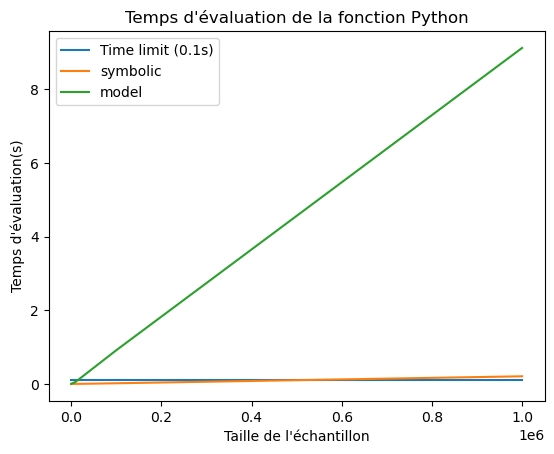

In [15]:
plt.title("Temps d'évaluation de la fonction Python")
plt.xlabel("Taille de l'échantillon")
plt.ylabel("Temps d'évaluation(s)")
plt.plot(sample_sizes, [0.1]*len(sample_sizes), label="Time limit (0.1s)")
plt.plot(sample_sizes, symbolic_time_list, label="symbolic")
plt.plot(sample_sizes, model_time_list, label="model") # Add subtitle to the plot
plt.legend()
plt.show()

On utilisera désormais l’implémentation via une fonction symbolique.
## 3.2 Variables d’entrée et de sortie
7. Créer le vecteur aléatoire X dans la variable X des sources d’incertitude.

In [16]:
X = ot.RandomVector(distribution_entrees)

8. Créer le vecteur aléatoire M dans la variable M correspondant à la masse de l’aile.

In [17]:
M = ot.CompositeRandomVector(model_masse, X)

9. Peut-on obtenir la distribution de `M` à l’aide de l’algèbre des distributions?

> Réponse : Non, on ne peut pas obtenir la distribution de `M` à l'aide de l'algèbre des distributions parceque le modèle est non-linéaire.

10. Calculer la distribution de la masse de la peinture à l’aide de l’algèbre des distributions et
tracer sa densité.

## 3.3 Analyse en tendance centrale
On effectue d’abord une analyse de la moyenne et de la variance de la masse à l’aide d’une
approximation de Taylor du modèle au point moyen des sources d’incertitudes à l’aide de la classe
TaylorExpansionMoments.

11. Que valent la moyenne à l’ordre 0 et la moyenne à l’ordre 2 de M? Le calcul précis de la
hessienne est-il critique?

> Réponse : La précision du calcul de la hessienne peut être importante pour estimer la variance de la sortie en utilisant l'approximation de Taylor. Si la hessienne est mal calculée, cela peut entraîner des erreurs dans l'estimation de la variance

In [18]:
# Effectuer une approximation de Taylor du modèle au point moyen des sources d'incertitudes
taylor_expansion_moments = ot.TaylorExpansionMoments(M)

# Calculer la moyenne d'ordre 0 et d'ordre 2 de M
mean_order_0 = taylor_expansion_moments.getMeanFirstOrder()
mean_order_2 = taylor_expansion_moments.getMeanSecondOrder()

print("Moyenne d'ordre 0 de M:", mean_order_0)
print("Moyenne d'ordre 2 de M:", mean_order_2)

Moyenne d'ordre 0 de M: [267.625]
Moyenne d'ordre 2 de M: [268.034]


WRN - You are using a default implementation for the hessian. Be careful, your computation can be severely wrong!


12. Que vaut la variance à l’ordre 1 de M?

In [19]:
# Calculer la variance d'ordre 1 de M
covariance_matrix_order_1 = taylor_expansion_moments.getCovariance()

print("Variance d'ordre 1 de M:",covariance_matrix_order_1[0, 0])

Variance d'ordre 1 de M: 2195.5616673651452


13. Calculer les facteurs d’importance des composantes de X dans la variance de M.

In [20]:
# Calculer les facteurs d'importance des composantes de X dans la variance de M
importance_factors = taylor_expansion_moments.getImportanceFactors()

print("Facteurs d'importance des composantes de X dans la variance de M:")
for i, factor in enumerate(importance_factors):
    print(f"{nom_sources[i]}: {100*factor:.5f} %")

Facteurs d'importance des composantes de X dans la variance de M:
Sw: 13.03154 %
Wfw: 0.00029 %
A: 22.81527 %
Lambda: 0.00000 %
q: 0.00825 %
l: 0.18027 %
tc: 13.50016 %
Nz: 41.27941 %
Wdg: 8.83317 %
Wp: 0.35162 %


14. On considère que la composante Xi est importante dès lors que son facteur d’importance est
supérieur à 0.5%. Quelles sont les composantes importantes et les composantes négligables
selon ce critère?

In [21]:
# Seuil d'importance
threshold = 0.005

important_components = []
negligible_components = []

for i, factor in enumerate(importance_factors):
    if factor > threshold:
        important_components.append(i)
    else:
        negligible_components.append(i)

print("Composantes importantes:", nom_sources[important_components])
print("Composantes négligeables:", nom_sources[negligible_components])

Composantes importantes: [Sw,A,tc,Nz,Wdg]
Composantes négligeables: [Wfw,Lambda,q,l,Wp]


On souhaite confronter cette analyse en calculant les indices de Sobol totaux de chacune des
composantes de X, calculés à partir de la décomposition de Sobol de la fonction de masse.

15. Construire la décomposition de Sobol du modèle à l’aide de l’algorithme FunctionalChaosAlgorithm
en utilisant un plan d’expérience de type Monte Carlo (classe MonteCarloExperiment) de
taille 1000 associé à la distribution des incertitudes.

In [22]:
inputDim = distribution_entrees.getDimension()
samplingSize=1000

# Building the multivariate orthonormal basis:
polyColl = [0.0]*inputDim
for i in range(inputDim):
    polyColl[i] = ot.StandardDistributionPolynomialFactory(distribution_entrees.getMarginal(i))
enumerateFunction = ot.LinearEnumerateFunction(inputDim)
productBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)

# We keep all the polynomials of degree <= 3

degree = 3
indexMax = enumerateFunction.getStrataCumulatedCardinal(degree)
adaptiveStrategy = ot.FixedStrategy(productBasis, indexMax)

# Definining the evaluation strategy of the coefficients:


experiment =ot.MonteCarloExperiment(distribution_entrees, samplingSize)
X = experiment.generate()
Y = symbolic_function(X)
projectionStrategy = ot.LeastSquaresStrategy()

chaos_algorithm = ot.FunctionalChaosAlgorithm(X, Y, distribution_entrees, adaptiveStrategy,
                                   projectionStrategy)
chaos_algorithm.run()
chaos_result = chaos_algorithm.getResult()


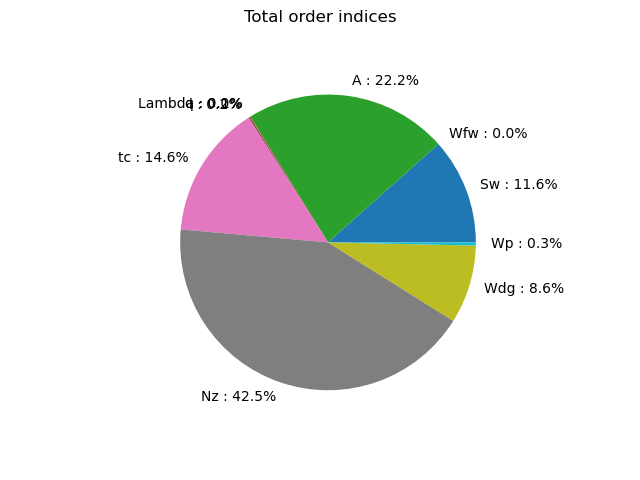

In [23]:
from openturns.viewer import View

sobol_indices = ot.SobolIndicesAlgorithm(chaos_result.getDistribution(), 1000, chaos_result.getMetaModel())
total_sobol_indices = sobol_indices.getTotalOrderIndices()
sobol_indices.DrawImportanceFactors(total_sobol_indices, nom_sources, 'Total order indices')


16. En générant un échantillon indépendant et de même taille, valider graphiquement la qualité
de la décomposition. On calculera également le coefficient de détermination. Pour cela, on
utilisera la classe MetaModelValidation.

In [24]:
validation_sample = distribution_entrees.getSample(samplingSize)
output_sample = symbolic_function(validation_sample)
validation = ot.MetaModelValidation(validation_sample, output_sample, chaos_result.getMetaModel())
R2 = validation.computePredictivityFactor()[0]
print(f"Coefficient of determination R^2: {R2}")


Coefficient of determination R^2: 0.9999907153436187


/home/odeck/.local/lib/python3.10/site-packages/openturns/viewer.py:655: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self._fig.show(**kwargs)


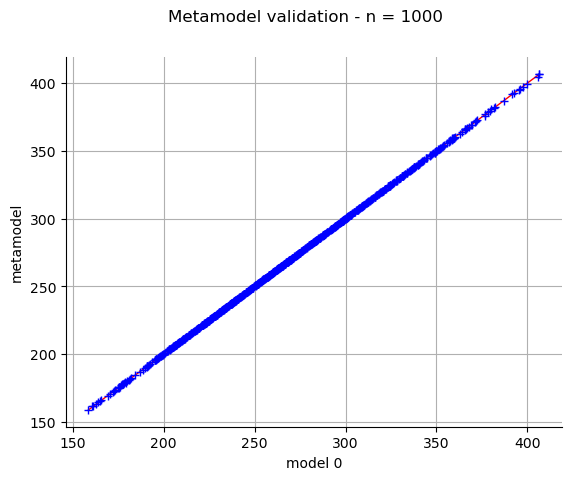

In [25]:
graph = validation.drawValidation()
View(graph).show()

17. En déduire une estimation des indices de Sobol totaux de chacune des composantes de X.
En appliquant le même critère que pour les facteurs d’importance issus du développement
de Taylor, quels sont les composantes influentes et celles qui ne le sont pas? Comparer avec
le classement obtenu précédemment.

Composantes importantes: [Sw,A,tc,Nz,Wdg]
Composantes négligeables: [Wfw,Lambda,q,l,Wp]


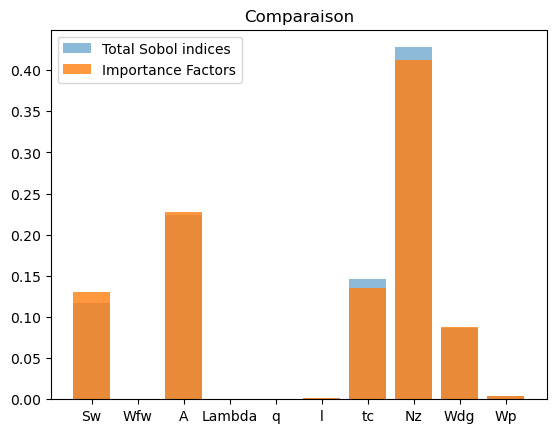

In [26]:
threshold = 0.005  # 0.5% threshold
influential_components = []
non_influential_components = []

# Seuil d'importance
threshold = 0.005

important_components = []
negligible_components = []


for i, index in enumerate(total_sobol_indices):
    if index > threshold:
        influential_components.append(i)
    else:
        non_influential_components.append(i)

print("Composantes importantes:", nom_sources[influential_components])
print("Composantes négligeables:", nom_sources[non_influential_components])

plt.title("Comparaison")
plt.bar(nom_sources, total_sobol_indices, label="Total Sobol indices", alpha=0.5)
plt.bar(nom_sources, importance_factors, label="Importance Factors", alpha=0.8)
plt.legend()


On souhaite tester le fait que certaines composantes de X ne sont pas influentes en les fixant à
leur valeur moyenne dans le modèle et à comparer le modèle réduit ainsi obtenu au modèle initial.

18. Construire le modèle réduit reliant les composantes influentes de X à M. On utilisera la
classe ParametricFunction.

In [27]:
reduced_input_distribution = ot.ComposedDistribution([distribution_entrees.getMarginal(i) for i in influential_components])


In [37]:
def constant_non_influential(input_distribution, non_influential_components):
    """
    """
    mean_values=[]
    for i in non_influential_components:
        mean_values.append(input_distribution.getMarginal(i).getMean()[0])
    return mean_values

In [38]:
mean_values=constant_non_influential(distribution_entrees, non_influential_components)
mean_values

[260.0, 0.0, 30.5, 0.75, 0.052500000000000005]

In [39]:
reduced_model = ot.ParametricFunction(symbolic_function, non_influential_components,mean_values )

19. Extraire l’échantillon marginal correspondant à ces composantes de l’échantillon de test
précédent.

In [41]:
test_sample = distribution_entrees.getSample(samplingSize)
influential_test_sample = test_sample.getMarginal(influential_components)

In [42]:
influential_test_sample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=1000 dimension=5 description=[Sw,A,tc,Nz,Wdg] data=[[183.871,8.22987,0.126488,4.31926,2024.27],[165.272,8.51793,0.0840976,3.83044,2049.27],[169.879,9.50086,0.149236,5.21295,2411.52],...,[174.21,8.49865,0.133787,4.12255,2309.27],[174.184,7.47787,0.131957,4.98455,1956.8],[153.969,6.73459,0.133077,3.03851,2019.37]]

20. En utilisant le modèle réduit comme méta-modèle du modèle initial, valider graphiquement
le fait qu’on puisse fixer les entrées incertaines non influentes à leur valeur moyenne. Que
vaut le coefficient de détermination?

In [43]:
from openturns import MetaModelValidation

full_model_output = symbolic_function(test_sample)
reduced_model_output = reduced_model(influential_test_sample)


validation = MetaModelValidation(influential_test_sample, full_model_output, reduced_model)
r_squared = validation.computePredictivityFactor()
print("Coefficient of determination (R-squared):", r_squared)

Coefficient of determination (R-squared): [0.993956]


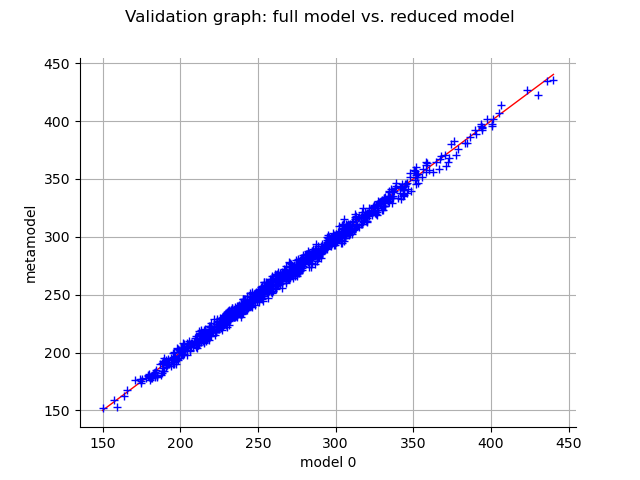

In [45]:
validation_graph = validation.drawValidation()
validation_graph.setTitle("Validation graph: full model vs. reduced model")
validation_graph

The validation graph compares the full model output (X-axis) with the reduced model output(y-axis). The closer the points are to the diagonal line, the better the reduced model approximates the full model which is the case in the graph abov. The computed R-squared value provides a measure of how well the reduced model explains the variability of the full model. A value close to 1 indicates a good fit.

## 3.4 Analyse d’un événement rare

On souhaite garantir avec grande probabilité que la masse de l’aile reste en dessous d’une limite
$M_{max} = 460$ lb. Pour cela, on souhaite calculer la probabilité de l’événement E = {M ≥ Mmax}.

21. Construire l’événement E.